## Проект: A/B–тестирование + SQL 

In [7]:
#Импортирую библиотеки
import pandas as pd 
import requests 
from urllib.parse import urlencode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
from scipy.stats import chi2_contingency, chi2 
from scipy.stats import bootstrap
import pandahouse as ph
import os

%matplotlib inline

1. Прочитаем файлы. 

Для этого напишу функцию, которая загружает дф по апи. 

In [8]:
def down_df(public_key):
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href']
    
    return download_url

Прочитаю файлы с данными:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [11]:
#не дает загрузить из-за лимита/пробовала через загрузку и из своего ЯД
#groups.csv
#public_key_1 = 'https://disk.yandex.ru/d/yIe-v1-2Ew6iWw'
#df_groups = pd.read_csv(down_df(public_key_1), sep=';')

#groups_add.csv
#public_key_2 = 'https://disk.yandex.ru/d/6T_nXraT5acZlw'
#df_groups_add = pd.read_csv(down_df(public_key_2), sep=',')

#active_studs.csv
#public_key_3 = 'https://disk.yandex.ru/d/eWQd0ew-TT7KAQ'
#df_active_studs = pd.read_csv(down_df(public_key_3), sep=';')

#checks.csv
#public_key_4 = 'https://disk.yandex.ru/d/L_oREC7EoYicWg'
#df_checks = pd.read_csv(down_df(public_key_4), sep=';')


После доработки не могу через апи загрузить файлы. Видимо это связано с превышением лимита скачиваний. Загружу дф по старинке

In [143]:
#groups.csv
df_groups = pd.read_csv(r'/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-kondrateva-44/Проект_2_groups.csv', sep=';')

#groups_add.csv

df_groups_add = pd.read_csv(r'/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-kondrateva-44/Проект_2_group_add.csv', sep=',')

#active_studs.csv

df_active_studs = pd.read_csv(r'/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-kondrateva-44/Проект_2_active_studs.csv', sep=';')

#checks.csv

df_checks = pd.read_csv(r'/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-kondrateva-44/Проект_2_checks.csv', sep=';')

2. Функция первичного обзора данных

In [144]:
#Функция первичного обзора данных
def review(df):
    display(df.head(5))
    print(df.info())
    print('Пропуски:', df.isna().sum())
    print('Явные дубликаты:')
    if df.duplicated().sum() > 0:
        print(df.duplicated().sum())
    else:
        print('Не найдено')

##### файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [145]:
review(df_groups)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None
Пропуски: id     0
grp    0
dtype: int64
Явные дубликаты:
Не найдено


##### дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [146]:
review(df_groups_add)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None
Пропуски: id     0
grp    0
dtype: int64
Явные дубликаты:
Не найдено


##### файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [147]:
review(df_active_studs)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None
Пропуски: student_id    0
dtype: int64
Явные дубликаты:
Не найдено


##### файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [148]:
review(df_checks)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None
Пропуски: student_id    0
rev           0
dtype: int64
Явные дубликаты:
Не найдено


Для решения первой задачи буду следовать такой логике: 

#### Первая часть - подготовка дф для дальнейшей работы.

1. Сначала нужно объединить два файла с данными по аб тестировнию
2. Смерджу датасет с активными юезрами и с юзерами, которые совершили покупку. У меня должен получиться дф, где будут все активные пользователи в дни проведения экспермимента. 
3. В получившемся дф я отмечу тех, кто совершил/не совершил покупку (0/1)
4. Затем я получившейся дф смерджу с данными по юзерам по аб эксперименту. 

Это будет итоговый дф для проведения анализа. 

1. Объединяю два файла по аб тестированию

 - **А – контроль**,
 - **B – целевая группа**

In [149]:
#дф с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
groups = pd.concat([df_groups,df_groups_add])

In [150]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [151]:
#Кол-во участников в группах
groups['grp'].value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [152]:
#В проц отношении
groups['grp'].value_counts(normalize=True).mul(100)

B    80.297951
A    19.702049
Name: grp, dtype: float64

In [153]:
groups.shape

(74576, 2)

2. Нужно получить файл с юзерами и их действиями, когда проходил эксперимент

Мне нужно получить всех юзеров, кто совершал и не совершал покупку с платформы, когда проходил эксперимент

Если я правильно рассуждаю, у нас пользователь заходит на платформу и на платформе есть система оплаты. Может ли он попасть сразу на оплату без посещения платформы? 

По логике мы должны таких пользователей исключить из анализа, потому что нам нужно смотреть только тех, кто с платформы пошел или не пошел на оплату. Так как мы тестировали новую механику оплаты.

Чтобы взять только пользователей перешедших или не перешедших на оплату с платформы, я возьму файл с данными, где хранятся пользователи, которые заходили на платформу в дни проведения эксперимента и объед. его с файлом, где хранится информация об оплатах. Оставлю только тех кто перешел или не перешел на оплату через платформу. Таким образом я должна отсечь тех, кто попал на оплату не через платфому

In [154]:
action_users = df_active_studs.merge(df_checks, how = 'left',on = 'student_id')

In [155]:
#Заменю все NaN значения на нули
action_users.fillna(0,inplace=True)

In [156]:
action_users.head()

,student_id,rev
0,581585,0.0
1,5723133,0.0
2,3276743,0.0
3,4238589,0.0
4,4475369,0.0


In [157]:
action_users.shape[0] == df_active_studs.shape[0]

True

In [158]:
action_users.shape

(8341, 2)

**Кол-во уникальных юзеров.**

Это те студенты, которые были активны и которым была предложена оплата/они совершили или не совершили покупку

In [159]:
#Кол-во уникальных юзеров.
action_users.student_id.nunique()

8341

Проверю все таки есть пользователи, которые оплатили без посещения платформы, когда проводился эксперимент. 

Как я это вижу: 

Я хочу объед эти же данные, только сделать полное внешнее объединение(outer), чтобы потом вычислить этих пользователей: вычту кол-во пользователей из action_users(где у меня хранятся пользователи, которые через платформу перешли на оплату)

In [160]:
#объед и получила дф
all_users = df_active_studs.merge(df_checks, how = 'outer',on = 'student_id')

In [161]:
#возьму кол-во уникальных пользов 
all_users.student_id.nunique()

8490

In [162]:
print(f'''Кол-во пользователей, которые совершили оплату без посещения платформы в дни проведения эксперимента
{all_users.student_id.nunique() - action_users.student_id.nunique()}''')

Кол-во пользователей, которые совершили оплату без посещения платформы в дни проведения эксперимента
149


Выходит такие пользователи есть. 

Значит моя логика решения должна быть правильной. Для дальнейшей работы я возьму action_users - этот дф


Добавлю отметку, если пользователь совершил/не совершил покупку. 1 - совершил. 0 - не совершил 


In [163]:
#если была покупка добавила 1, если нет 0 
action_users['purch'] = action_users['rev'].apply(lambda x: 1 if x > 0 else 0)

action_users.head()

,student_id,rev,purch
0,581585,0.0,0
1,5723133,0.0,0
2,3276743,0.0,0
3,4238589,0.0,0
4,4475369,0.0,0


Для корректного объед получившегося дф с файлом, где хранятся данные по аб тесту, мне нужно переименовать колоенку с id. 

In [164]:
#в дф с информацией о принадлежности пользователя к контрольной или экспериментальной группе изменю название колонки
groups.rename(columns = {'id':'student_id'},inplace=True)

In [165]:
groups.head(1)

,student_id,grp
0,1489,B


Объединение файла с данными по аб тесту + файлом с действиями активных пользователей.

In [166]:
df_students = groups.merge(action_users,on='student_id')

In [167]:
df_students.head(10)

,student_id,grp,rev,purch
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0
5,22994,B,0.0,0
6,26899,B,0.0,0
7,27079,B,0.0,0
8,29021,B,0.0,0
9,98633,B,0.0,0


In [168]:
df_students.shape

(8341, 4)

##### Подготовила файл для дальнейшего анализа - df_students.

In [169]:
df_students.shape

(8341, 4)

In [170]:
df_students.dtypes

student_id      int64
grp            object
rev           float64
purch           int64
dtype: object

In [171]:
#Посмотрим на распределнение кол-ва  в группах 
df_students['grp'].value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [172]:
#В процентном отношении 
df_students['grp'].value_counts(normalize =True).mul(100).round(2)

B    81.56
A    18.44
Name: grp, dtype: float64

###### Визуальное представление, кол-во участников в группах

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


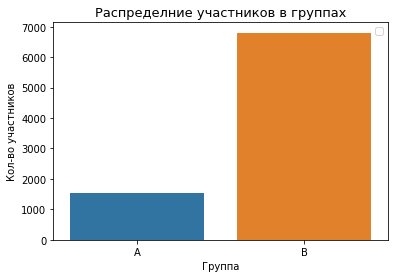

In [173]:
sns.countplot(df_students['grp'])

plt.title('Распределние участников в группах', fontsize=13)
plt.xlabel("Группа")
plt.ylabel("Кол-во участников")
plt.legend()
plt.show()

### Небольшой вывод: 

При предподготовке данных я выяснила: 

1. При распределении пользователей на аб группы у нас было общее кол-во 74576 пользователя. В контрольной группе было 14693 это почти 20% от общего числа. В экспер.группе было 59883 это около 80% от общего. 
   
   В эксперименте участвовало 8341 пользователя. В контрольной группе 1538 это 18% от общего числа. В экспер.группе 6803 почти 82% от общего числа. 
   
   
2. Были пользователи(149), которые совершили оплату, но без посещения образовательной платформы во время проведения эксперимента. Я их не буду брать в анализ и в расчет метрик, потому что аб тест расчитан на активных пользователей, те кто идет с образовательной платформы.




#### Приступим к выполнению второй части этого задания.
Буду решать по след.логике:
1. Выделю метрики для анализа
2. Нахождение различий в показателях, с чем связано.
3. Проверка на стат значимые различия анализируемых метрик 
4. Вывод: стоит ли запускать новую механику. 

**1. На какие метрики Вы смотрите в ходе анализа и почему?**

Что должно улучшиться, чтобы мы могли сделать вывод об эффективности воздействия? Нас интересуют целевые метрики. Значит мы должны смотреть: 
1. Как изменилась конверсия в покупку
2. Выросла или снизилась выручка 1го платящего и неплатящего пользователя. 

Соответственно я  выделю следующие метрики:
- Конверсия в покупку;
- ARPU - средняя выручка на 1го пользователя;
- ARPAU (Average Revenue Per Active User) - средний платеж на всех активных пользователей. Более точно отражает ситуацию нежели ARPU.

###### Посмотрю на активных пользователей, кто оплачивал: 
- какой самый популярный чек в группах
- какой был максим чек в группах 

In [174]:
df_students.head()

,student_id,grp,rev,purch
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


In [175]:
df_students.shape

(8341, 4)

Выделю в отдельные дф группу А и В

In [176]:
grp_A = df_students[df_students['grp'] == 'A']
grp_B = df_students[df_students['grp'] == 'B']

Посмотрю сколько оплат было совершенно в группах

In [177]:
#Процент.отношение тех кто совершил и не совершил покупку в группе А - группа со старой механикой оплаты
grp_A['purch'].value_counts(normalize=True).mul(100)

0    94.928479
1     5.071521
Name: purch, dtype: float64

In [178]:
#Процент.отношение тех кто совершил и не совершил покупку в группе B - группа с новой механикой оплаты
grp_B['purch'].value_counts(normalize=True).mul(100)

0    95.384389
1     4.615611
Name: purch, dtype: float64

Популярный чек в группах. Как он отличается от средней суммы по группе.

In [179]:
#Популярный чек в группе А - со старой механикой оплаты
grp_A.query('purch == 1')['rev'].value_counts()

290.0     25
580.0      6
990.0      5
590.0      5
199.0      5
690.0      4
840.0      3
3660.0     3
1530.0     3
1160.0     2
1140.0     2
2820.0     2
489.0      2
2910.0     2
2900.0     1
1830.0     1
2220.0     1
1980.0     1
870.0      1
398.0      1
2890.0     1
1180.0     1
1039.0     1
Name: rev, dtype: int64

In [180]:
#Средний чек в группе А == 934
grp_A_mean_rev = grp_A.query('purch == 1').rev.mean().round()

grp_A_mean_rev

934.0

In [181]:
#Медианный чек в группе А
grp_A_median_rev = grp_A.query('purch == 1').rev.median().round()

grp_A_median_rev

585.0

В контрольной группе, самый часто встречающийся чек == 290. 

In [182]:
#Популярный чек в группе B - группа с новой механикой оплаты
grp_B.query('purch == 1')['rev'].value_counts()

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
398.0000      6
590.0000      6
1530.0000     5
580.0000      5
870.0000      5
2099.0000     3
2890.0000     3
1980.0000     2
2910.0000     2
3660.0000     2
1968.0000     1
880.0000      1
3040.0000     1
796.0000      1
2190.0000     1
1160.0000     1
1729.0000     1
2220.0000     1
4650.0000     1
1339.0000     1
1388.0000     1
489.0000      1
3260.0000     1
1050.0000     1
597.0000      1
Name: rev, dtype: int64

In [183]:
#Средний чек в группе B == 1258
grp_B_mean_rev = grp_B.query('purch == 1').rev.mean().round()

grp_B_mean_rev

1258.0

In [184]:
#Медианный чек в группе B
grp_B_median_rev = grp_B.query('purch == 1').rev.median().round()

grp_B_median_rev

1140.0

##### Визализация - распределние чека в контрольной и экспер. группах

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


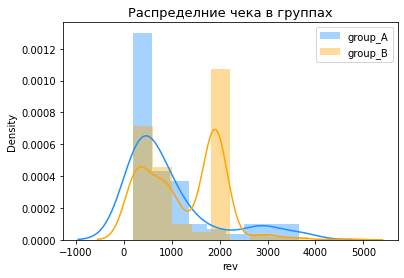

In [185]:
#Посмторим график распределения
sns.distplot(grp_A.query('purch == 1')['rev'],color="dodgerblue", label="group_A",kde=True)
sns.distplot(grp_B.query('purch == 1')['rev'],color="orange", label="group_B",kde=True)


# Decoration
plt.title('Распределние чека в группах', fontsize=13)
plt.legend()
plt.show()

##### Выявила разницу между пользователями в группах:

- У нас в эксп. группе самый популярный чек на 1900, а в контрольной группе лидирует по частоте встречаемости чек на 290. Это может говорить о том, что в группе б у нас пользователи были активнее и, возможно, было акционное предложение на этот чек в момент проведения эксперимента, поэтому так много покупок на эту сумму. В подтверждении этой версии можно еще привести такой довод, что следующие по популярности чеки в группе б это: 290, 199 и 840. 
- Еще нужно взять во внимание, что есть чек на 1900. Но также есть чек == 1900.0001. Скорее всего это баг. И имеется ввиду одна стоимость == 1900.
- Также среднее значение и медианное значение чека в группе б выше, чем в группе а. Это также подтверждает, что в группе б пользователи были активнее. Интересно почему? Это буду анализировать дальше, смотреть на метрики и проверять на стат.значимые различия.
- Распределние чека в обоих группах ненормальное, есть выбросы. 
- Выше я выяснила, что у нас оказались 149 пользователей, которые совершили покупку без посещения платорфы. Я их не буду учитывать при расчете метрик. Выше обосновывала. 


### Анализ метрик

Так, я выделила следующие метрики:

1. Конверсия в покупку;
2. ARPU - средняя выручка на 1го пользователя;
3. ARPAU (Average Revenue Per Active User) - средний платеж на всех активных пользователей. Более точно отражает ситуацию нежели ARPU. == Средний чек (ARPPU)

### 1. Анализ метрики - CR в покупку

Формула: 

CR = (Кол-во клиентов, совершивших покупку / Все клиенты) * 100%

In [186]:
df_students.head()

,student_id,grp,rev,purch
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


Для каждой группы посчитаю:
- кол-во уникальных клиентов - count_students;
- общую выручку для каждой группы - total_rev;
- кол-во реальных клиентов, кто совершил покупку - total_purch


In [187]:
df_for_cr = df_students.groupby('grp',as_index=False).agg({'student_id':'nunique',
                               'rev':'sum',
                               'purch':'sum'}) \
                                        .rename(columns={'student_id':'count_students',
                                                        'rev':'total_rev',
                                                        'purch':'total_purch'})

df_for_cr

,grp,count_students,total_rev,total_purch
0,A,1538,72820.0000,78
1,B,6803,394974.0035,314


In [188]:
#Добавлю колонку с конверсией в покупку 
df_for_cr['cr'] = round((df_for_cr['total_purch'] / df_for_cr['count_students']) * 100,2)

In [189]:
df_for_cr

,grp,count_students,total_rev,total_purch,cr
0,A,1538,72820.0000,78,5.07
1,B,6803,394974.0035,314,4.62


Получается, что в тестовой группе конверсия в покупку ниже, чем в контрольной группе. Нужно теперь понять эти различия статистически значимы или нет.

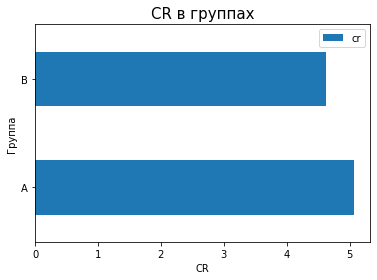

In [190]:
#Визуализация: значение CR в контрольной и тестовой группах

df_for_cr[['grp','cr']].set_index('grp').plot(kind='barh')

plt.title('CR в группах', fontsize=15)
plt.xlabel("CR",fontsize=10)
plt.ylabel("Группа",fontsize=10)
plt.legend()
plt.show()

#### Сформулирую гипотезы, которые буду проверять в этом эксперименте
1. Нулевая гипотеза (H0): Разницы между конверсией в покупку в тестовой и контрольной группе нет

2. Альтернативная гипотеза (H1): Разница между конверсией в покупку в тестовой и контрольной группе есть

Выбор стат теста зависит к какому типу метрика относится. Мы сейчас работаем с конверсией в покупку. Это метрика относится к пропорционным метрикам == пропорция. 
Наилучший метод чтобы проверить статистическую значимость изменения для пропорций это метод Хи‑Квадрат.

In [191]:
#Выделю в отдельную таблицу нужные данные для стат теста. Функция chi2_contingency принимает на вход табличку.

t = df_for_cr[['grp','count_students','total_purch']]

In [192]:
#становлю столбец в качестве индекса 
t.set_index('grp',inplace=True)

In [193]:
#Получившаяся таблица, для стат теста. 
t

,count_students,total_purch
grp,,
A,1538,78
B,6803,314


In [194]:
stat, p, dof, expected = chi2_contingency(t)

In [195]:
stat, p

(0.43612258061018483, 0.5089998823014525)

##### Интерпретируем результат:

In [196]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Получили статистически значимые различия. Нулевая гипотеза отклоняется')
else:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')

Не получили статистически значимых различий. Альтернативная гипотеза отклоняется


**Вывод:**

Для проверки этой гипотезы я использую ХИ-КВАДРАТ, поскольку эту метрику можно отнести к пропорции. Альтернативная гипотеза ОТКЛОНЯЕТСЯ, поскольку p-value > 0. 05. Значит, значимых различий в конверсии между группами не наблюдается.

### 2. Анализ метрики - ARPU - средняя выручка на 1го пользователя

Формула: 

ARPU = Доход / Кол-во уникальных пользователей

Также можно использовать этот дф для расчета этой метрики - **df_for_cr**

In [197]:
#сохраню в отдельный дф нужные колонки

df_metrics = df_for_cr[['grp','count_students','total_rev']].copy()

In [198]:
#расчитаю нужную метрику
df_metrics['ARPU'] = round(df_metrics['total_rev']/df_metrics['count_students'],2)

In [199]:
df_metrics[['grp','ARPU']]

,grp,ARPU
0,A,47.35
1,B,58.06


Получается, что в ARPU средняя выручка на 1го пользователя в тестовой группе выше, чем в контрольной. Проверю это различия стат значимо или нет. 

#### Сформулирую гипотезы, которые буду проверять в этом эксперименте
1. Нулевая гипотеза (H0): Разницы между arpu в тестовой и контрольной группе нет

2. Альтернативная гипотеза (H1): Разница между arpu в тестовой и контрольной группе есть


Выбор стат теста. У меня есть две группы и метрика APRU является количественной переменной (средняя выручка на 1го пользов.), поэтому т-тест будет более подходящим выбором.

In [200]:
#Выделю выборки для проведения стат.теста
arpu_A = df_students.query('grp == "A"').rev
arpu_B =df_students.query('grp == "B"').rev

##### Визуализация распределения данных в группах

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


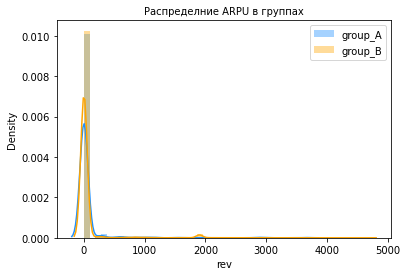

In [201]:
#Посмотрю на распределение

sns.distplot(arpu_A,color="dodgerblue", label="group_A",kde=True)
sns.distplot(arpu_B, color="orange", label="group_B",kde=True)

# Decoration
plt.title('Распределние ARPU в группах', fontsize=10)
plt.legend()
plt.show()

Распределние не похоже на нормальное, оно скошено влево. Обычно при таких вводных используют непараметрику, но насколько мне известно из лекций, что т-тест можно использовать. Я думаю значения адекватные, поскольку в каждой выборке около 5% платящих пользователей. Остальные 95% не совершили покупку. 


In [202]:
#Для сравнения метрики в экспериментальной и контрольной группах я использую STUDENT'S T-TEST
_, p = stats.ttest_ind(arpu_A, arpu_B)
if p > 0.05:
    print('Не получили статистически значимых различий. Альтернативная гипотеза отклоняется')
else:
    print('Нулевая гипотеза отклоняется. Получили стат значимые различия')

Не получили статистически значимых различий. Альтернативная гипотеза отклоняется


##### Вывод

В ходе этого эксперимента я не получила статистически значимых различий между метрикой **ARPU** в группе с БАЗОВОЙ МЕХАНИКОЙ ОПЛАТЫ  и с НОВОЙ МЕХАНИКОЙ ОПЛАТЫ. 

### 3. Анализ метрики - ARPPU

In [203]:
df_students.head()

,student_id,grp,rev,purch
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


In [204]:
#Выделю выборки для проведения стат.теста
ARPPU_A = df_students.query('grp == "A" and purch>0').rev
ARPPU_B = df_students.query('grp == "B" and purch>0').rev

In [205]:
# значение среднего чека в группах 

print(f'Значение ARPPU в КОНТРОЛЬНОЙ ГРУППЕ {round(ARPPU_A.mean(),2)}')
print()
print(f'Значение ARPPU в ТЕСТОВОЙ ГРУППЕ {round(ARPPU_B.mean(),2)}')

Значение ARPPU в КОНТРОЛЬНОЙ ГРУППЕ 933.59

Значение ARPPU в ТЕСТОВОЙ ГРУППЕ 1257.88


Получается, что доход от платящего пользователя в тестовой группе больше, чем в контрольной. Нужно теперь понять эти различия статистически значимы или нет.

#### Сформулирую гипотезы, которые буду проверять в этом эксперименте
1. Нулевая гипотеза (H0): Разницы между ARPPU в тестовой и контрольной группе нет

2. Альтернативная гипотеза (H1): Разница между ARPPU в тестовой и контрольной группе есть


##### Визуализирую распределние 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


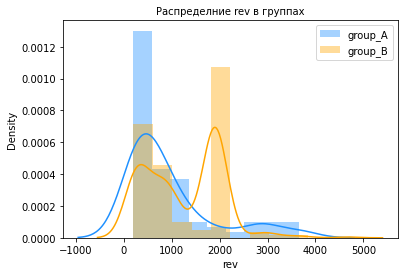

In [208]:
#Посмотрю на распределение

sns.distplot(ARPPU_A,color="dodgerblue", label="group_A",kde=True)
sns.distplot(ARPPU_B, color="orange", label="group_B",kde=True)

# Decoration
plt.title('Распределние rev в группах', fontsize=10)
plt.legend()
plt.show()

Распределние не похоже на нормальное. 
Проведу стат тесты:
1. Тест на проверку условий нормальности
2. Гомогенность дисперсий


**Проверю выполнение условий на нормальность.**

In [209]:
# Кнтрольная группа проверка выборки на нормальность 
_,p = stats.normaltest(ARPPU_A)
if p < 0.05:
    print(f'Значения в контрольной выборке распределены ненормально p-value:{p}')
else:
    print(f'Значения в контрольной выборке распределены нормально p-value:{p}')

Значения в контрольной выборке распределены ненормально p-value:2.5316868804220266e-07


In [210]:
# Тестовая группа проверка выборки на нормальность 
_,p = stats.normaltest(ARPPU_B)
if p < 0.05:
    print(f'Значения в тестовой выборке распределены ненормально p-value:{p}')
else:
    print(f'Значения в тестовой выборке распределены нормально p-value:{p}')

Значения в тестовой выборке распределены ненормально p-value:0.033445723194625424


**Гомогенность дисперсий**

In [211]:
#Проверка на гомогенность дисперсий с помощью критерия Левена.

_, p = stats.levene(ARPPU_A, ARPPU_B)
if p > 0.05:
    print('Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.')
else:
    print('Дисперсии в наших группах различны. Требование гомогенности дисперсия не соблюдается')

Дисперсии внутри наших групп одинаковы. Требование гомогенности дисперсий соблюдается.


Выходит требование гомогенности дисперсий соблюдается, но значения в выборке в обоих группах распределены ненормально.
Можно провести т-тест, как я делала с прошлой метрикой, но думаю следует применить бутстрап для сравнения ARPPU. 

##### Подготовим данные для загрузки в бутстрап

In [212]:
#Данные для бутстрапа
sample_A = (df_students.query('grp == "A" and purch > 0').rev, )
sample_B = (df_students.query('grp == "B" and purch > 0').rev, )

###### Bootstrap ддя контрольной группы

In [215]:
#Кладем в функцию выборку и выбераем показатель - среднее
bootstrap(sample_A, np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=756.2755847894987, high=1159.6616291251812), standard_error=102.50376087736122)

###### Bootstrap ддя тестовой группы

In [216]:
#Кладем в функцию выборку и выбераем показатель - среднее
bootstrap(sample_B, np.mean) #--- выдает ошибку

BootstrapResult(confidence_interval=ConfidenceInterval(low=1171.7103324385034, high=1347.0148974689803), standard_error=44.93639395803596)

##### Вывод

Интервалы не пересекаются. Это позволяет с высокой степенью вероятности делать выводы о том, что результат оказался статистически ЗНАЧИМ.

## Вывод по 1 Заданию 

1. В ходе анализа первое, что я выяснила, что было неравномерное распределение по группам. В контрольной группе было 14693 это почти 20% от общего числа. В экспер.группе было 59883 это около 80% от общего. В эксперименте участвовало 8341 пользователя. В контрольной группе 1538 это 18% от общего числа. В экспер.группе 6803 почти 82% от общего числа. Я думаю, это в итоге могло сказаться на результате аб теста. 
2. Также, были обнаружены 149 пользователей, которые совершили оплату, но без посещения образовательной платформы во время проведения эксперимента. Скорее всего они перешли сразу на оплату, может быть, это было специальное предложение. 
3. Проведенный анализ показал, что в группе б пользователи вели себя активно и самый популярный чек был на 1900т, могу предположить, что в дни проведения эксперимента, была запущена акция, выгодное предложение. Либо это были новые пользователи и они вели себя активнее. Это может говорить о неверном делении на группы. 
4. Я выделила 3 метрики для нахождения стат значимых различий между группами. Две метрики, а именно: конверсия в покупку и ARPU не дали стат значимых различий, это была случайная флуктуация. 

Статистический анализ метрик показал, что в группе пользователей с новой механикой оплаты - статистически увеличился средний чек платящего пользователя, они активнее покупали, самый популярный чек был на 1900т. Повторюсь, видимо была запущена акция/выгодное предложение/рекл компания. Также я анализировала конверсию в покупку и ARPU в группах, анализ не дал статистически значимых различий. Механика оплаты повлияла только на доход от платящих пользователей, но не повлияла на конверсию. Скорее всего на увеличение среднего чека плат пользователей повлиял не запуск новой механики оплаты, а что-то другое. 

5. Я думаю пока не нужно катить новую механику оплаты на всех пользователей. Нужно разобраться, что могло повлиять на увеличение ARPPU. А также разобраться как были сформированы группы для теста. Учесть все ошибки и провести другой аб тест. 

## Задание 2. SQL
**2.1 Очень усердные ученики.**

**2.1.1 Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**2.1.2 Задача**
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [93]:
#Подключаемся к кликхаусу

connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [94]:
def select(sql):
    return ph.read_clickhouse(query=sql, connection=connection_default)

In [95]:
# создаем запрос, db автоматически заменится на значение из database
sql = '''
    SELECT st_id,
           toStartOfMonth(timest) as month,
           correct, subject
    FROM {db}.peas   
    '''

In [96]:
#Загрузила для просмотра данные
df_all = select(sql)

In [97]:
df_all.head()

,st_id,month,correct,subject
0,100379,2021-10-01,1,Theory of probability
1,100379,2021-10-01,0,Vizualization
2,100379,2021-10-01,1,Theory of probability
3,100379,2021-10-01,1,Vizualization
4,100379,2021-10-01,1,Theory of probability


In [98]:
# создаем запрос, о количестве очень усердных студентов
sql = '''

SELECT COUNT(st_id) as students
FROM(
SELECT st_id,
       toStartOfMonth(timest) as timest,
       COUNT(correct) as count_correct
FROM {db}.peas
WHERE correct = 1
GROUP BY st_id, toStartOfMonth(timest) as timest
HAVING count_correct >= 20) as t
    '''

In [99]:
smart_st = select(sql)

print(f'Количество усердных студентов: {smart_st.students[0]}')

Количество усердных студентов: 136


**2.2 Оптимизация воронки**

**2.2.1 Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

**2.2.2 Задача**

Даны таблицы: default.peas , default.studs, default.final_project_check

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.


Сначала изучу каждую таблицу. Загружу в панд дф

In [113]:
# создаем запрос, db автоматически заменится на значение из database
sql = '''
    SELECT st_id,
           toDate(timest) as act_time,
           correct, subject
    FROM {db}.peas  
    '''
#сохранаю первую табл в панд дф
peas = select(sql)
peas.head()

,st_id,act_time,correct,subject
0,100379,2021-10-30,1,Theory of probability
1,100379,2021-10-30,0,Vizualization
2,100379,2021-10-30,1,Theory of probability
3,100379,2021-10-30,1,Vizualization
4,100379,2021-10-30,1,Theory of probability


In [114]:
peas.st_id.count()

13245

In [115]:
#Кол-во уникальных студентов 
peas.st_id.nunique()

308

In [116]:
# создаем запрос, db автоматически заменится на значение из database
sql = '''
    SELECT st_id,
           test_grp
    FROM {db}.studs  

'''
#сохраняю вторую табл в панд дф
studs = select(sql)
studs.head()

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [117]:
studs.st_id.count()

600

In [118]:
#Кол-во уникальных студентов
studs.st_id.nunique()

600

In [119]:
# создаем запрос, db автоматически заменится на значение из database
sql = '''
    SELECT st_id,
           toDate(sale_time) as sale_time, money, subject
    FROM {db}.final_project_check  

'''
#сохраняю третью табл в панд дф
final_project_check = select(sql)
final_project_check.head()

,st_id,sale_time,money,subject
0,101432,2021-10-31,85000,Math
1,101432,2021-10-31,65000,Vizualization
2,104885,2021-10-30,65000,Vizualization
3,104885,2021-10-30,75000,Statistics
4,106464,2021-10-31,85000,Math


In [120]:
final_project_check.st_id.count()

61

In [121]:
final_project_check.st_id.nunique()

47

1. ARPU = доход / на кол-во уникальных пользователей
2. ARPAU = доход от акт юзеров / кол-во уник актив юзеров
3. CR в покупку = кол-во купивших юзеров / общее кол-во уник юзеров
4. СR активного пользователя в покупку  = кол-во активных кто сов покупку / общее кол-во активн юзеров
5. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике = кол-во акт купивш по математике / кол-во активных по математике 



Изначально моя логика решения задачи была такой:  из дф peas я посчитала по каждому студенту общее кол-во решенных горошин и решенных горошин по математике. Получившийся дф я объединила с дф final_project_check - где хранится инфа с оплатами. И затем готовый дф я объед с studs, где хранится инфа с пользователями по аб тесту.
Проверив итоговую сумму по чекам, у меня не сошлоись данные, получилось, что в итоговом дф сумма меньше, чем в final_project_check - где хранится инфа с оплатами.
Пришла к выводу, что были такие участники эксперимента, которые не решали задачи, а сразу купили неограниченный доступ. Их тоже нужно учитывать при расчете метрик. 

In [122]:
sql = '''
SELECT 
test_grp,
round(SUM(money) / COUNT(DISTINCT st_id),2) as ARPU,
ROUND(SUM(money) FILTER (WHERE total_correct > 10) / COUNT(DISTINCT st_id) FILTER (WHERE r.total_correct > 10),2) as ARPAU,
ROUND(COUNT(DISTINCT st_id) FILTER (WHERE money > 0) / COUNT(DISTINCT st_id) * 100,2) as CR_total,
ROUND(COUNT(DISTINCT st_id) FILTER (WHERE money > 0 AND total_correct > 10) / COUNT(DISTINCT st_id) FILTER (WHERE total_correct > 10) * 100,2) as CR_active_st,
ROUND(COUNT(DISTINCT st_id) FILTER (WHERE money > 0 AND correct_math >= 2 AND subject = 'Math') / COUNT(DISTINCT st_id) FILTER (WHERE correct_math >=2) * 100,2) as CR_active_math_st

FROM (SELECT st_id,
       test_grp,
       money,
       subject
FROM {db}.studs 
LEFT JOIN {db}.final_project_check
USING (st_id)) as l 

LEFT JOIN (SELECT st_id,
       SUM(correct) as total_correct,
       SUM(correct) FILTER(WHERE subject = 'Math') as correct_math
FROM {db}.peas
GROUP BY st_id) as r

USING (st_id)
GROUP BY test_grp'''

In [123]:
metrics = select(sql)

In [124]:
metrics

,test_grp,ARPU,ARPAU,CR_total,CR_active_st,CR_active_math_st
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


In [125]:
print(f'''ARPU в группе Pilot увеличился на  \
{round(metrics.query('test_grp == "pilot"').ARPU[1]/metrics.query('test_grp == "control"').ARPU[0],2)}
ARPAU в группе Pilot увеличился на \
{round(metrics.query('test_grp == "pilot"').ARPAU[1]/metrics.query('test_grp == "control"').ARPAU[0],2)}
CR в покупку в группе Pilot увеличился на \
{round(metrics.query('test_grp == "pilot"').CR_total[1]/metrics.query('test_grp == "control"').CR_total[0],2)}
CR активного пользователя в покупку в группе Pilot увеличился на \
{round(metrics.query('test_grp == "pilot"').CR_active_st[1]/metrics.query('test_grp == "control"').CR_active_st[0],2)}
CR пользователя из активности по математике в покупку курса по математике \
{round(metrics.query('test_grp == "pilot"').CR_active_math_st[1]/metrics.query('test_grp == "control"').CR_active_math_st[0],2)}
''')

ARPU в группе Pilot увеличился на  2.53
ARPAU в группе Pilot увеличился на 2.86
CR в покупку в группе Pilot увеличился на 2.21
CR активного пользователя в покупку в группе Pilot увеличился на 2.36
CR пользователя из активности по математике в покупку курса по математике 1.56



Мы получили следующие метрики в группах. Показатели в тестовой группе выше чем в контрольной группе, нужно проверять если стат.значимые различия в группах и делать вывод стоит ли запускать новый экран оплаты на всех юзеров

## Задание 3. Python

**3.1 Задача**

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [133]:
def calculate_metrics(link_groups_add):
    '''
    Функция, которая будет автоматически подгружать информацию из дополнительного файла
    groups_add.csv и на основании дополнительных параметров пересчитывать метрики.
    '''
    # Загрузка данных из дополнительного файла. Возьму код из первого задания. 
    
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    #groups.csv
    public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
    
    #groups_add.csv
    public_key_groups_add = link_groups_add
    
    #active_studs.csv
    public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
    
    #checks.csv
    public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

    
    
    # получаем url 
    groups_url = base_url + urlencode(dict(public_key=public_key_groups))
    groups_add_url = base_url + urlencode(dict(public_key=public_key_groups_add))
    active_studs_url = base_url + urlencode(dict(public_key=public_key_active_studs))
    checks_url = base_url + urlencode(dict(public_key=public_key_checks))
    
    
    groups_response = requests.get(groups_url) 
    groups_add_response = requests.get(groups_add_url)
    active_studs_response = requests.get(active_studs_url)
    checks_response = requests.get(checks_url)
    
    download_groups_url = groups_response.json()['href']
    download_groups_add_url = groups_add_response.json()['href']
    download_active_studs_url = active_studs_response.json()['href']
    download_checks_url = checks_response.json()['href']
    
    df_groups = pd.read_csv(download_groups_url, sep=';')
    df_groups_add = pd.read_csv(download_groups_add_url, sep=',')
    df_active_studs = pd.read_csv(download_active_studs_url, sep=';')
    df_checks = pd.read_csv(download_checks_url, sep=';')
    
    
    # Далее также возьму код из первого задания. Объед дф для получения итогового для подсчета метрик
    #Объед файлы с инф по аб тесту
    groups = pd.concat([df_groups,df_groups_add])
    
    #Объед файл, где хран данные по акт юзерам с данные, где хран оплаты пользов
    action_users = df_active_studs.merge(df_checks, how = 'left',on = 'student_id')
    
    #Заменю все NaN значения на нули
    action_users.fillna(0,inplace=True)
    
    if action_users.shape[0] == df_active_studs.shape[0]:
        #если была покупка добавила 1, если нет 0 
        action_users['purch'] = action_users['rev'].apply(lambda x: 1 if x > 0 else 0)
        
        #в дф с информацией о принадлежности пользователя к контрольной или экспериментальной группе изменю название колонки
        groups.rename(columns = {'id':'student_id'},inplace=True)
        df_students = groups.merge(action_users,on='student_id')
        #Подготовила файл для дальнейшего анализа - df_students.
        
        #Подсчет метрик
        
        df_metrics = df_students.groupby('grp', as_index = False).agg({'student_id':'nunique',
                                                     'purch':'sum',
                                                     'rev':'sum'}).rename(columns={'student_id':'all_st',
                                                                     'purch':'pay_st',
                                                                     'rev':'total_rev'})
        
        df_metrics['CR'] = round((df_metrics['pay_st'] / df_metrics['all_st']) * 100,2)
        df_metrics['ARPU'] = round((df_metrics['total_rev'] / df_metrics['all_st']),2)
        df_metrics['ARPPU'] = round((df_metrics['total_rev'] / df_metrics['pay_st']),2)
        
        return df_metrics  
        
    else:
        return 'При объединении произошла ошибка'

**Функция, которая будет строить графики по получаемым метрикам**

In [136]:
def plot_metrics(data):
    '''
    Функция, которая будет строить графики по получаемым метрикам
    '''
    #Строим графики
    plt.figure(figsize=(15, 10))
    
    # CR 
    plt.subplot(2, 2, 1)
    sns.barplot(data = data,x='CR',y='grp')
    plt.title('Конверсия в покупку')
    plt.ylabel('Группа')
    plt.xlabel('CR(%)')
    
    #ARPU
    plt.subplot(2, 2, 2)
    sns.barplot(data = data,x='ARPU',y='grp')
    plt.title('Средняя выручка на одного пользователя')
    plt.ylabel('Группа')
    plt.xlabel('ARPU')
    
    #APRRU
    plt.subplot(2, 2, 3)
    sns.barplot(data = data,x='ARPPU',y='grp')
    plt.title('Средняя выручка на одного ПЛАТЯЩЕГО пользователя')
    plt.ylabel('Группа')
    plt.xlabel('APRRU')
    
    return plt.show()
    
    

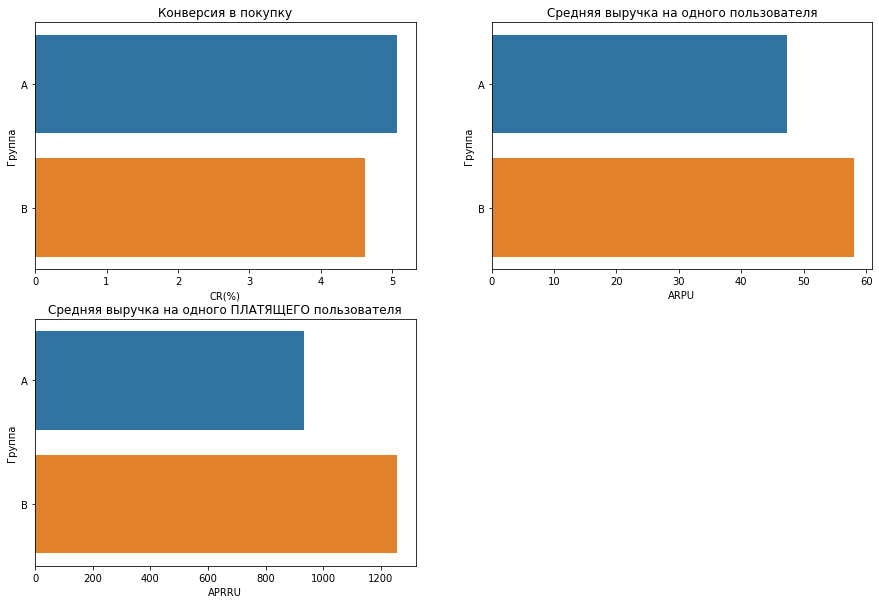

In [137]:
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

dfs = calculate_metrics(public_key)
plot_metrics(dfs)